In [6]:
import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor

from torch.utils.data import DataLoader
from typing import Mapping

from miniai.training import *
from miniai.datasets import *
     

mpl.rcParams['image.cmap'] = 'gray'

In [3]:
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In [4]:
x_imgs = x_train.view(-1,28,28)
xv_imgs = x_valid.view(-1,28,28)
     

mpl.rcParams['figure.dpi'] = 30
     

<Axes: >

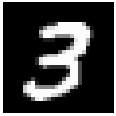

In [13]:
im3 = x_imgs[7]
show_image(im3)

In [17]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0 ,0],
                   [ 1 ,1 ,1]]).float()

<Axes: >

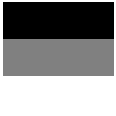

In [18]:
show_image(top_edge)

In [19]:
df = pd.DataFrame(im3[:13,:23])
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


In [26]:
(im3[3:6,14:17]*top_edge).sum()

tensor(2.9727)

tensor(-0.0234)

In [48]:
def apply_kernel_MT(im, kernel): 
    r,c = im.shape
    imgkern = torch.zeros(r,c)
    for i in range(1,r-2):
        for j in range(1,c-2):
            imgkern[i,j] = (im[i-1:i+2,j-1:j+2]*kernel).sum()
    return imgkern

torch.Size([28, 28])

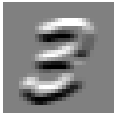

In [49]:
test = apply_kernel_MT(im3, top_edge)
show_image(test)
test.shape


In [47]:
[[(i,j) for j in range(5)] for i in range(5)]

[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],
 [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]]

In [52]:
def apply_kernel(row,col,kernel): return (im3[row-1:row+2,col-1:col+2]*kernel).sum()

<Axes: >

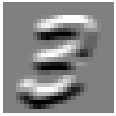

In [59]:
test2 = [[apply_kernel(i,j,top_edge) for j in range(1,27)] for i in range(1,27)]
show_image(test2)

In [60]:
import torch.nn.functional as F
import torch

In [61]:
im3.shape

torch.Size([28, 28])

In [64]:
inp = im3[None,None,:,:].float()
inp_unf = F.unfold(inp, (3,3))[0]
inp_unf.shape

torch.Size([9, 676])

In [65]:
w = left_edge.view(-1)
w.shape

NameError: name 'left_edge' is not defined

In [67]:
F.conv2d(im3[None], top_edge)

RuntimeError: weight should have at least three dimensions

In [72]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

In [73]:
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

In [74]:
left_edge = tensor([[-1,0,1],
                    [-1,0,1],
                    [-1,0,1]]).float()

In [71]:
xb = x_imgs[:16][:,None]
xb.shape

torch.Size([16, 1, 28, 28])

In [75]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:,None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [76]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

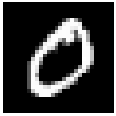

In [77]:
img0 = xb[1,0]
show_image(img0);

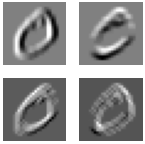

In [78]:
show_images([batch_features[1,i] for i in range(4)])

In [79]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [80]:
def conv(ni, nf, ks=3 ,stride=2, act=True):
    res = nn.Conv2d(ni,nf,stride=stride,kernel_size=ks,padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [83]:
simple_cnn = nn.Sequential(
    conv(1,4),     #14*14
    conv(4,8),    #7*7
    conv(8,16),    #4
    conv(16,16),   #2
    conv(16,10, act=False),  #1
    nn.Flatten()
    )

In [84]:
simple_cnn(xb).shape

torch.Size([16, 10])

In [85]:

x_imgs = x_train.view(-1,1,28,28)
xv_imgs = x_valid.view(-1,1,28,28)
train_ds,valid_ds = Dataset(x_imgs, y_train),Dataset(xv_imgs, y_valid)

In [105]:
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))

In [106]:

from torch import optim

bs = 256
lr = 0.4
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

In [107]:
xxb, yyb = next(iter(train_dl))

In [108]:
xxb.shape

torch.Size([256, 1, 28, 28])

In [109]:
loss,acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

/home/metao/fastai2023/part2/.conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


0 0.3814475311279297 0.8850000001907349
1 0.23061883993148805 0.9335000002861022
2 0.11658584961891175 0.964200000667572
3 0.12520425651073455 0.9598000003814697
4 0.0997743016242981 0.9723999993324279


In [110]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr/4)
loss,acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.08540442657470704 0.9755999996185303
1 0.08266713259220124 0.9766999995231629
2 0.08420867087841034 0.9760999995231628
3 0.08249362993240357 0.9769999995231629
4 0.08230459611415863 0.9769999995231629
